# Booking.com Feature Extraction
---

Download the file BookingDotCom_HotelReviews.xlsx from Canvas. This file contains over 515,000 guest reviews and rating of almost 1500 hotels across Europe scraped from popular hotel reservation website Booking.com. The text data was cleaned by removing unicode and punctuation and transformed to lower case. No other preprocessing was done. More information on each field is provided in the "Data Description" tab of the Excel file.

        1. What are the top five hotel features (e.g., location, staff, etc.) that customers mention the most in positive reviews and top five features they mention most in negative reviews? Your identified features must make sense (e.g., "great" or "negative" are not features). (3 points)
        
        2. What are the top five features that customers prefer most if they are a solo traveler vs traveling with a group vs on a business trip vs a leisure trip vs traveling as a couple vs a family with young children. You will find these categories in the "Tags" column. There are a few more tags that we don't need. (2 points).

        3. What are the top five features customers like most and top five features they complain about most about hotels in United Kingdom, France, Italy, and Spain? Country information is available inside Hotel_Address. (2 points)
        
        4. Create a dashboard with the following plots; (1) "Top Five Hotels Overall" with consistently high ratings, (2) Bottom Five Hotels Overall" with consistently low ratings, (3) Five Most Improved Hotels" with the highest improvement in average ratings from 2015 to 2017, showing their average ratings for each of the three years. (0.5+0.5+2 points).

Write clear, compact, and understandable code with comment/markdown statements as appropriate. Non-working code or unnecessary code will be penalized. 

Submit your Jupyter file using the link below or provide a link to your Google Colab or Github file.


In [3]:
# import packages to use
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pycountry
import ast
import spacy
from sklearn.feature_extraction.text  import CountVectorizer

### Load dataframe

In [4]:
df = pd.read_excel("BookingDotCom_HotelReviews.xlsx", sheet_name="Data") # original file

# df = df[:1500]

# rename df columns to lower case
df.columns = df.columns.str.lower()

### Remove numbers from text using regular expressions

In [5]:
df['positive_comments'] = df['positive_comments'].apply(lambda x: re.sub(r'\d+', '', str(x)))
df['negative_comments'] = df['negative_comments'].apply(lambda x: re.sub(r'\d+', '', str(x)))

### Lemmatize, remove stopwords and convert to lowercase using spaCy

In [6]:
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

# remove stopwords
myStopwords = list(load_model.Defaults.stop_words)
myStopwords.append('negative')
myStopwords.append('positive')
myStopwords.append('hotel')
#.append('positive'), 'stay', 'hotel', 'night', 'book', 'com')

def lemmaFunc(text):
    doc = load_model(text)
    allowed_tags = ['NOUN', 'PROPN']        # to get only nouns and proper nouns
    return " ".join([token.lemma_.lower() for token in doc if token.pos_ in allowed_tags \
                          and token.text.lower() not in myStopwords
                          ])

df['positive_comments'] = df['positive_comments'].apply(lambda x: lemmaFunc(x))
df['negative_comments'] = df['negative_comments'].apply(lambda x: lemmaFunc(x))

### Create a column of country names

In [7]:
# we get the list of countries from the pycountry package and use the hotel_address column to extract country name
df['country'] = df["hotel_address"].apply(
    lambda address: ' '.join([c.name for c in pycountry.countries if c.name in address])
    )

# use the review_date column to extract the year and store in new column
df['year'] = pd.DatetimeIndex(df['review_date']).year
#df['year'] = df['year'].astype(str)[:4].astype(int)

### Get customer groupings from column of tags

In [8]:
'''
In this step we deal with the tags column using the steps defined below:
    1. Define tags we are interested in
    2. Define a function to apply to tags column to remove tags we are not interested in by:
            - Converting the individual row values to list (from string) e.g. "[' Leisure trip ']" -> [' leisure trip ']
            - Strip the whitespaces from individual elements e.g. [' leisure trip ']-> ['leisure trip']
            - Drop tags we are not interested in
'''

# customer tags we are interested in
customer_tags = ['solo traveler','group','business trip','leisure trip','couple','family with young children']


def clean_tag(x):

    # convert value from string to a list
    myTags = ast.literal_eval(x.lower())

    # strip whitespaces from elements and drop those we are not interested in
    myTags = [customerTag.strip() for customerTag in myTags if customerTag.strip() in customer_tags]

    return myTags

# apply clean_tag() function to the tags column
df['tags'] = df['tags'].apply(lambda x: clean_tag(x))


'''
Function applied to tags column to extract new columns for customer categories
Lambda function will be used as in the steps below
'''

def split_tag(x:list, tagName:str) -> int:
    
    t = [1 if tagName in x else 0][0]
    
    return t


# dictionary of column names (new additional columns) and customer tags (as contained in tags of interest)
tagDict = {
    'solo_traveler' : 'solo traveler',
    'group' : 'group',
    'business_trip' : 'business trip',
    'leisure_trip' : 'leisure trip',
    'couple' : 'couple',
    'family_with_young_children' : 'family with young children'
}

# applying function on tags column to get new separated columns
for key, value in tagDict.items():
    df[key] = df['tags'].apply(lambda x: split_tag(x, value))

##### Saving dataframe for future use
---

In [9]:
# df.to_csv("dfProcessed.csv", index=False)

---

### Get word frequencies using CountVectorizer from sklearn

In [10]:
vecPos = CountVectorizer(
                        strip_accents='ascii', stop_words='english',
                        analyzer='word', max_df=0.95,max_features=500
                        )

vecNeg = CountVectorizer(max_df=0.85, ngram_range=(1,2), max_features=500)

sparseVecPos = vecPos.fit_transform(df['positive_comments'])   # You can fit and transform jointly 
sparseVecNeg = vecNeg.fit_transform(df['negative_comments'])

# create dataframes from the vectors of counts
matPos = pd.DataFrame(sparseVecPos.toarray(), columns=vecPos.get_feature_names_out())
matNeg = pd.DataFrame(sparseVecNeg.toarray(), columns=vecNeg.get_feature_names_out())

### Top 5 hotel features that customers mention the most in positive reviews

In [11]:
matPos.agg(sum).sort_values(ascending=False)[:5]

staff        195767
location     193406
room         178534
breakfast     85384
bed           63664
dtype: int64

### Top 5 hotel features that customers mention the most in negative reviews

In [12]:
matNeg.agg(sum).sort_values(ascending=False)[:5]

room         208790
breakfast     58508
staff         39756
bed           37187
night         28413
dtype: int64

### Top 5 features that customers prefer most by category: solo, couple, group etc

In [13]:
# indices of customer group data subsets (by travel tag)
soloIndex = df.index[df.solo_traveler != 0] # solo_traveler
groupIndex = df.index[df.group != 0] # group
businessIndex = df.index[df.business_trip != 0] # business_trip
leisureIndex = df.index[df.leisure_trip != 0] # leisure_trip
coupleIndex = df.index[df.couple != 0] # couple
familyIndex = df.index[df.family_with_young_children != 0] # family_with_young_children

Solo

In [14]:
matPos.iloc[soloIndex].agg(sum).sort_values(ascending=False)[:5]

location     39174
room         36639
staff        36623
breakfast    15716
bed          11184
dtype: int64

Group

In [15]:
matPos.iloc[groupIndex].agg(sum).sort_values(ascending=False)[:5]

staff        25100
location     24133
room         21148
breakfast    10769
bed           8513
dtype: int64

Business

In [16]:
matPos.iloc[businessIndex].agg(sum).sort_values(ascending=False)[:5]

location     28691
staff        25318
room         25273
breakfast    12234
bed           7664
dtype: int64

Leisure

In [17]:
matPos.iloc[leisureIndex].agg(sum).sort_values(ascending=False)[:5]

staff        165222
location     160398
room         148617
breakfast     71056
bed           54297
dtype: int64

Couple

In [18]:
matPos.iloc[coupleIndex].agg(sum).sort_values(ascending=False)[:5]

staff        99426
location     93807
room         91227
breakfast    42780
bed          34203
dtype: int64

Family with young children

In [19]:
matPos.iloc[familyIndex].agg(sum).sort_values(ascending=False)[:5]

location     23797
staff        23004
room         19904
breakfast    11116
bed           6687
dtype: int64

### Top 5 liked/complained about features by country (UK, France, Italy, Spain)

In [20]:
# United Kingdom likes/complaints
print("\nLiked: \n", matPos.iloc[df.index[df.country == 'United Kingdom']].agg(sum).sort_values(ascending=False)[:5])
print("\nComplained about:\n", matNeg.iloc[df.index[df.country == 'United Kingdom']].agg(sum).sort_values(ascending=False)[:5])


Liked: 
 staff        97550
location     93513
room         89558
breakfast    37191
bed          34865
dtype: int64

Complained about:
 room         117572
breakfast     31124
bed           21395
staff         21313
bathroom      15605
dtype: int64


In [21]:
# France likes/complaints
print(matPos.iloc[df.index[df.country == 'France']].agg(sum).sort_values(ascending=False)[:5])
print('\n')
print(matNeg.iloc[df.index[df.country == 'France']].agg(sum).sort_values(ascending=False)[:5])

location     26894
staff        24760
room         20762
breakfast     7504
bed           6733
dtype: int64


room         23423
breakfast     6712
staff         4094
bathroom      3083
bit           3067
dtype: int64


In [22]:
# Italy likes/complaints
print(matPos.iloc[df.index[df.country == 'Italy']].agg(sum).sort_values(ascending=False)[:5])
print('\n')
print(matNeg.iloc[df.index[df.country == 'Italy']].agg(sum).sort_values(ascending=False)[:5])

location     13171
room         12885
staff        12607
breakfast    11004
station       4688
dtype: int64


room         11778
breakfast     4868
staff         2935
bit           1994
night         1915
dtype: int64


In [55]:
# Spain likes/complaints
print(matPos.iloc[df.index[df.country == 'Spain']].agg(sum).sort_values(ascending=False)[:5])
print('\n')
print(matNeg.iloc[df.index[df.country == 'Spain']].agg(sum).sort_values(ascending=False)[:5])

location     25183
staff        24726
room         19846
breakfast     9664
bed           6672
dtype: int64


room         21007
breakfast     5717
staff         4254
bed           4184
pool          3781
dtype: int64


### Top 5 Hotels Overall with consistently high ratings

In [24]:
overallRatings = df[['hotel_name', 'average_hotel_score']].groupby(['hotel_name']).mean()

Text(0.5, 1.0, 'Top 5 Hotels Overall')

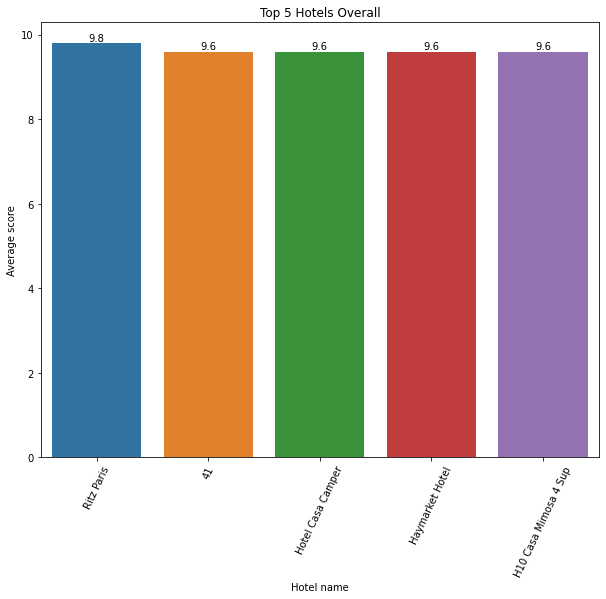

In [50]:
# top 5 hotels
topOverall = overallRatings.sort_values(by=['average_hotel_score'], ascending=False)[:5].reset_index()

plt.figure(figsize=(10,8))

x_labels = list(topOverall.hotel_name)

fig = sns.barplot(data=topOverall, x='hotel_name', y='average_hotel_score')
fig.bar_label(fig.containers[0]) # add numerical value to top of bars

plt.xlabel('Hotel name')
plt.ylabel('Average score')
plt.xticks(rotation=65)
plt.title('Top 5 Hotels Overall')

### Bottom 5 Hotels Overall with consistently low ratings

Text(0.5, 1.0, 'Bottom 5 Hotels Overall')

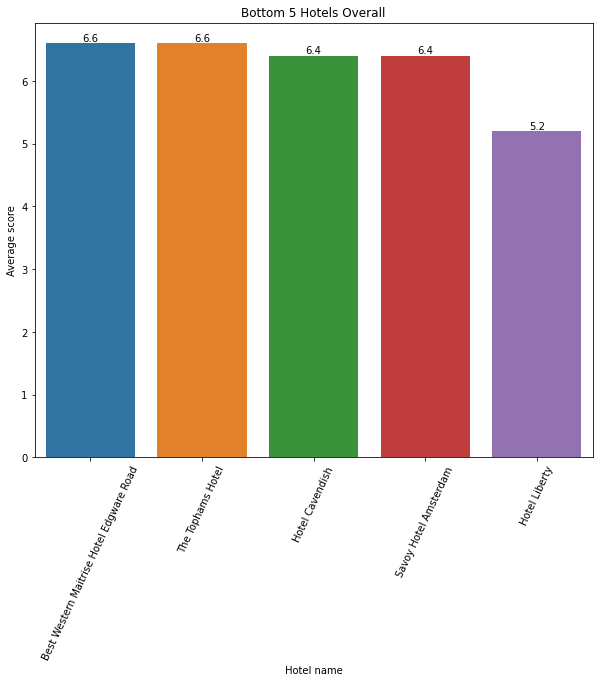

In [49]:
# create a dataframe of bottom 5 hotels ordered by average score and plot
bottomOverall = overallRatings.sort_values(by=['average_hotel_score'])[:5].reset_index()

plt.figure(figsize=(10,8))

fig = sns.barplot(
                    data=bottomOverall,x='hotel_name', y='average_hotel_score', 
                    order=bottomOverall.sort_values('average_hotel_score', ascending=False).hotel_name
                    )
                    
fig.bar_label(fig.containers[0]) # add numerical value to top of bars

plt.xlabel('Hotel name')
plt.ylabel('Average score')
plt.xticks(rotation=65)
plt.title('Bottom 5 Hotels Overall')

### 5 most improved hotels with the highest improvement in average ratings from 2015 to 2017 

In [27]:
# create a pivot table to get columns of different years
table = pd.pivot_table(df, values='reviewer_score', index=['hotel_name'], columns=['year'], aggfunc='mean')

# save to a csv to use later
# table.to_csv(".../pivoted.csv")

In [33]:
# load the saved pivoted table as a dataframe
pivoted = pd.read_csv("C:/Users/echemochek/OneDrive/Desktop/pivoted.csv")

# add a new column showing improvement from 2015 to 2017
pivoted['improvement'] = pivoted['2017'] - pivoted['2015']

# sort the dataframe by column of improvement scores
pivoted.sort_values(by='improvement', ascending=False, inplace=True)

Text(0.5, 1.0, 'Top 5 Most Improved Hotels (2015 to 2017)')

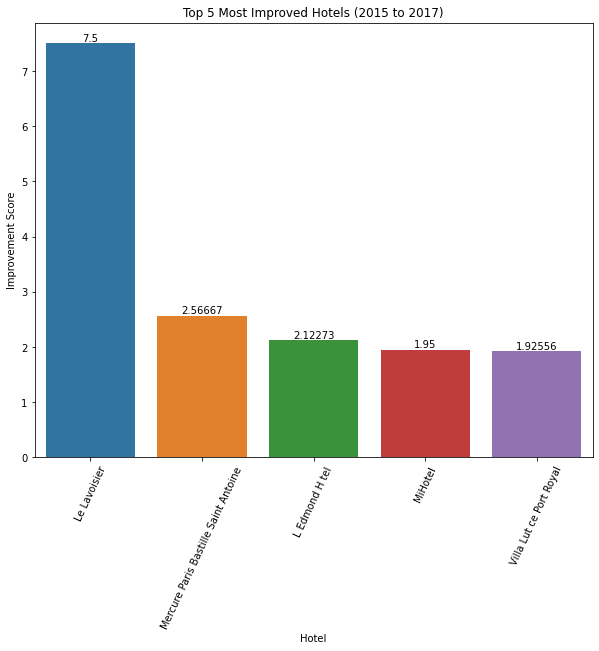

In [54]:
# plot the top 5 most improved hotels
plt.figure(figsize=(10,8))

fig = sns.barplot(data=pivoted[:5], x='hotel_name', y='improvement')
fig.bar_label(fig.containers[0])

plt.xlabel("Hotel")
plt.ylabel("Improvement Score")
plt.xticks(rotation=65)
plt.title("Top 5 Most Improved Hotels (2015 to 2017)")